In [26]:
from astropy.io import ascii, fits
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord

import ligo.skymap.plot

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as lines
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

data_dir = 'data'

## load data

In [33]:
# Reading all these files need about 3 mins
cigale_fagn0 = ascii.read(os.path.join(data_dir, 'cigale_fagn0.dat'), format='basic', guess=False, fast_reader={'chunk_size': 100*1000000})
cigale_float = ascii.read(os.path.join(data_dir, 'cigale_float.dat'), format='basic', guess=False, fast_reader={'chunk_size': 100*1000000})
src_table = ascii.read(os.path.join(data_dir, 'src_table.dat'), format='basic', guess=False, fast_reader={'chunk_size': 100*1000000})
len(src_table)

3262183

In [34]:
ra = src_table['RA']
dec = src_table['DEC']
cigale_coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)

VLA: https://iopscience.iop.org/article/10.1088/0004-6256/142/1/3

In [31]:
Hodge11 = ascii.read(os.path.join(data_dir, 'stripe82_2010may25.cat'), format='no_header', data_start=2, delimiter=' ', 
                      names=['h', 'm', 's', 'deg', 'min', 'sec', 'P(S)', 'Fpeak', 'Fint', 'RMS', 'Maj', 'Min', 'PA', 
                             'fMaj', 'fMin', 'fPA', 'Field', '#', 'Sep', 'i', 'Cl'])
Hodge11['RA'] = Hodge11['h']*u.h + Hodge11['m']*u.min + Hodge11['s']*u.s
Hodge11['Dec'] = Hodge11['deg']*u.deg + Hodge11['min']*u.arcmin + Hodge11['sec']*u.arcsec
len(Hodge11)

17969

3977

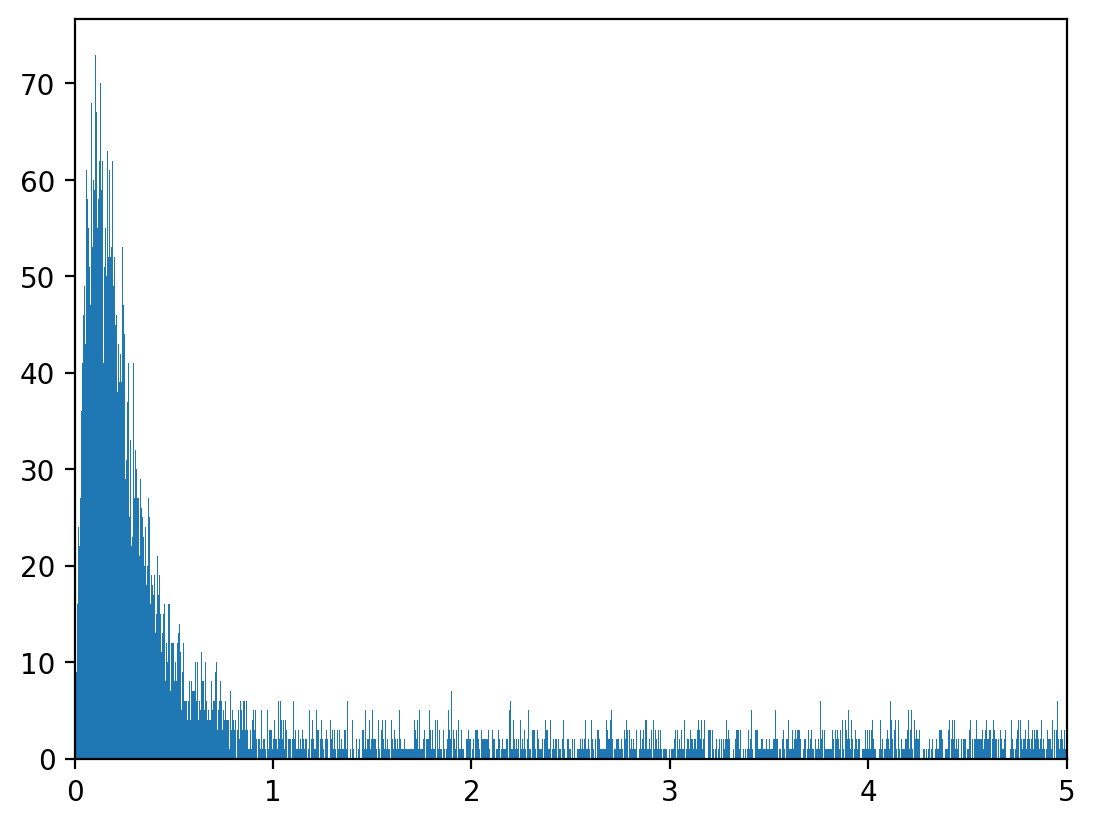

In [142]:
Hodge11_coord = SkyCoord(ra=Hodge11['RA'], dec=Hodge11['Dec'])

idx, d2d, d3d = cigale_coord.match_to_catalog_3d(Hodge11_coord)

max_sep = 1*u.arcsec
Hodge11_sel = d2d<max_sep

plt.hist(d2d.arcsec[d2d.arcsec<5], bins=1000)
plt.xlim(0, 5)

np.count_nonzero(Hodge11_sel)

X-Ray + WISE AGNs: https://iopscience.iop.org/article/10.1088/0004-6256/142/1/3

In [48]:
with fits.open(os.path.join(data_dir, 's82x_eboss_catalog_submitted.fits')) as hdu: 
    Lamassa19 = Table(hdu[1].data)
len(Lamassa19)

4847

(3320, 1952, 1351, 10)

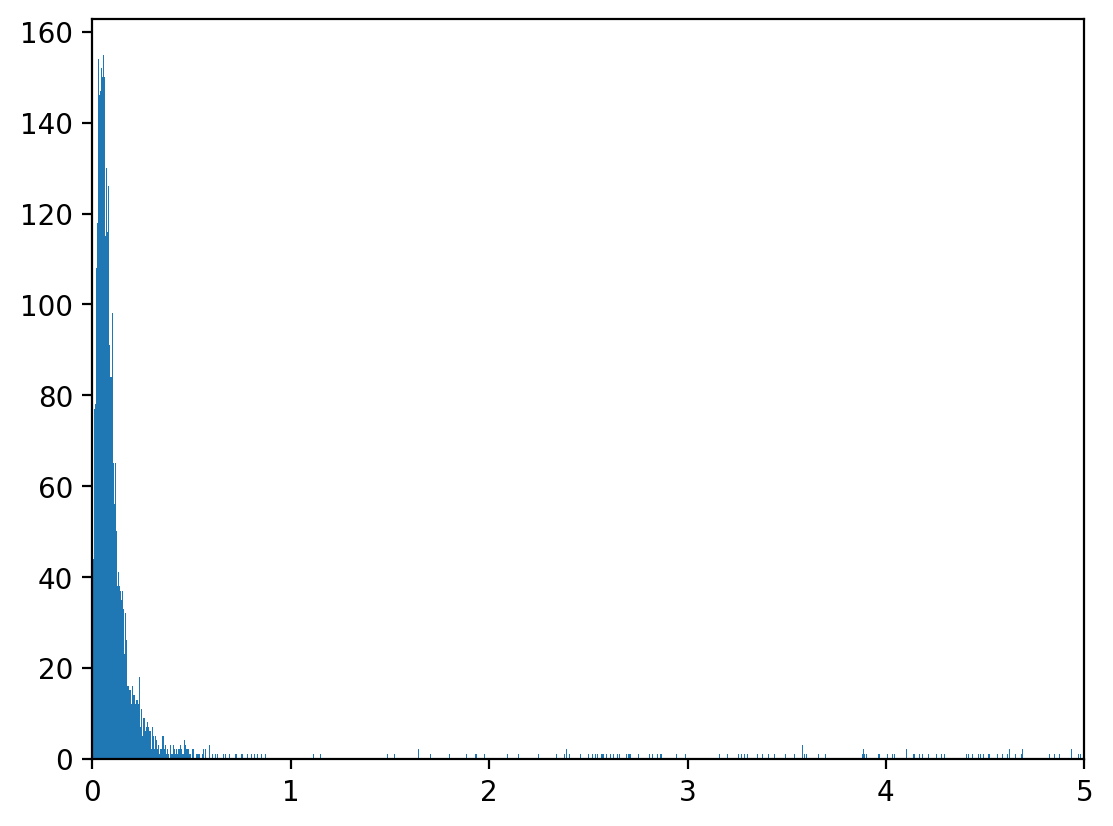

In [143]:
Lamassa19_coord = SkyCoord(ra=Lamassa19['SDSS_RA']*u.deg, dec=Lamassa19['SDSS_Dec']*u.deg)

idx, d2d, d3d = cigale_coord.match_to_catalog_3d(Lamassa19_coord)

max_sep = 1*u.arcsec
Lamassa19_sel = d2d<max_sep

Lamassa19QSO_sel = (Lamassa19_sel) & (Lamassa19[idx]['class']=='QSO')
Lamassa19Gal_sel = (Lamassa19_sel) & (Lamassa19[idx]['class']=='GALAXY')
Lamassa19Star_sel = (Lamassa19_sel) & (Lamassa19[idx]['class']=='STAR')

plt.hist(d2d.arcsec[d2d.arcsec<5], bins=1000)
plt.xlim(0, 5)

np.count_nonzero(Lamassa19_sel), np.count_nonzero(Lamassa19QSO_sel), np.count_nonzero(Lamassa19Gal_sel), np.count_nonzero(Lamassa19Star_sel)

(0.0, 5.0)

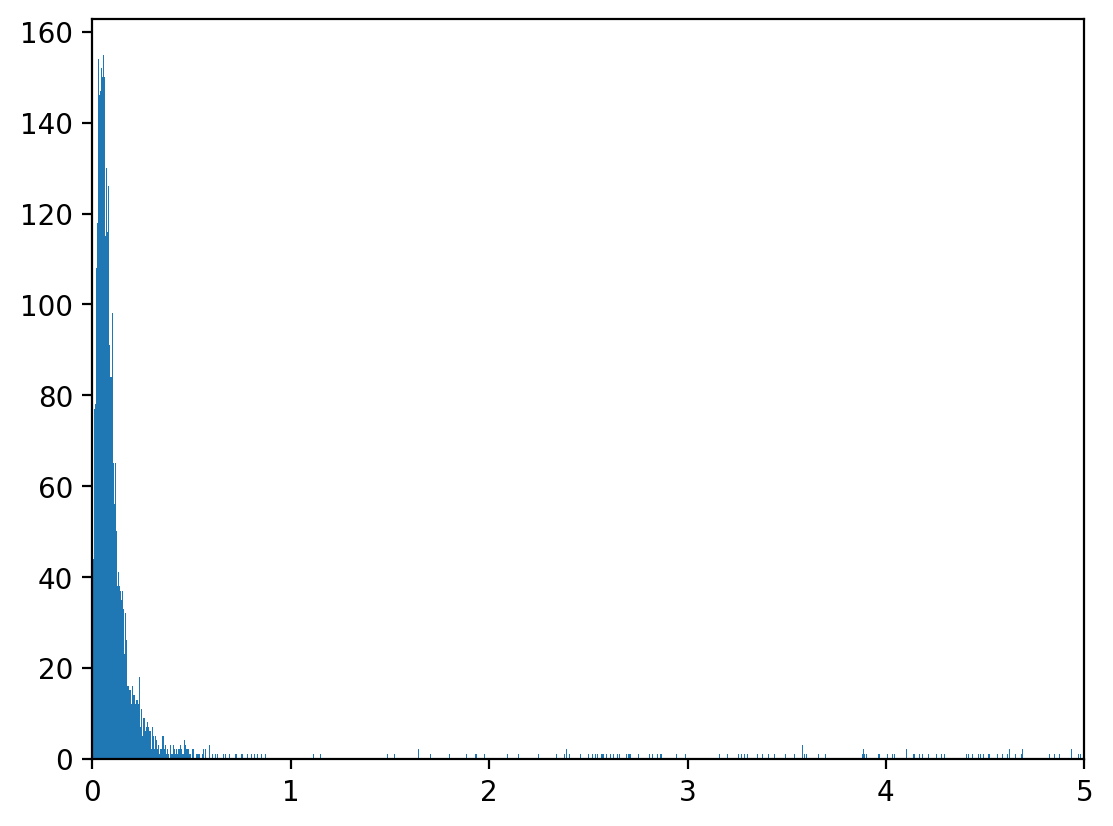

## Source profile

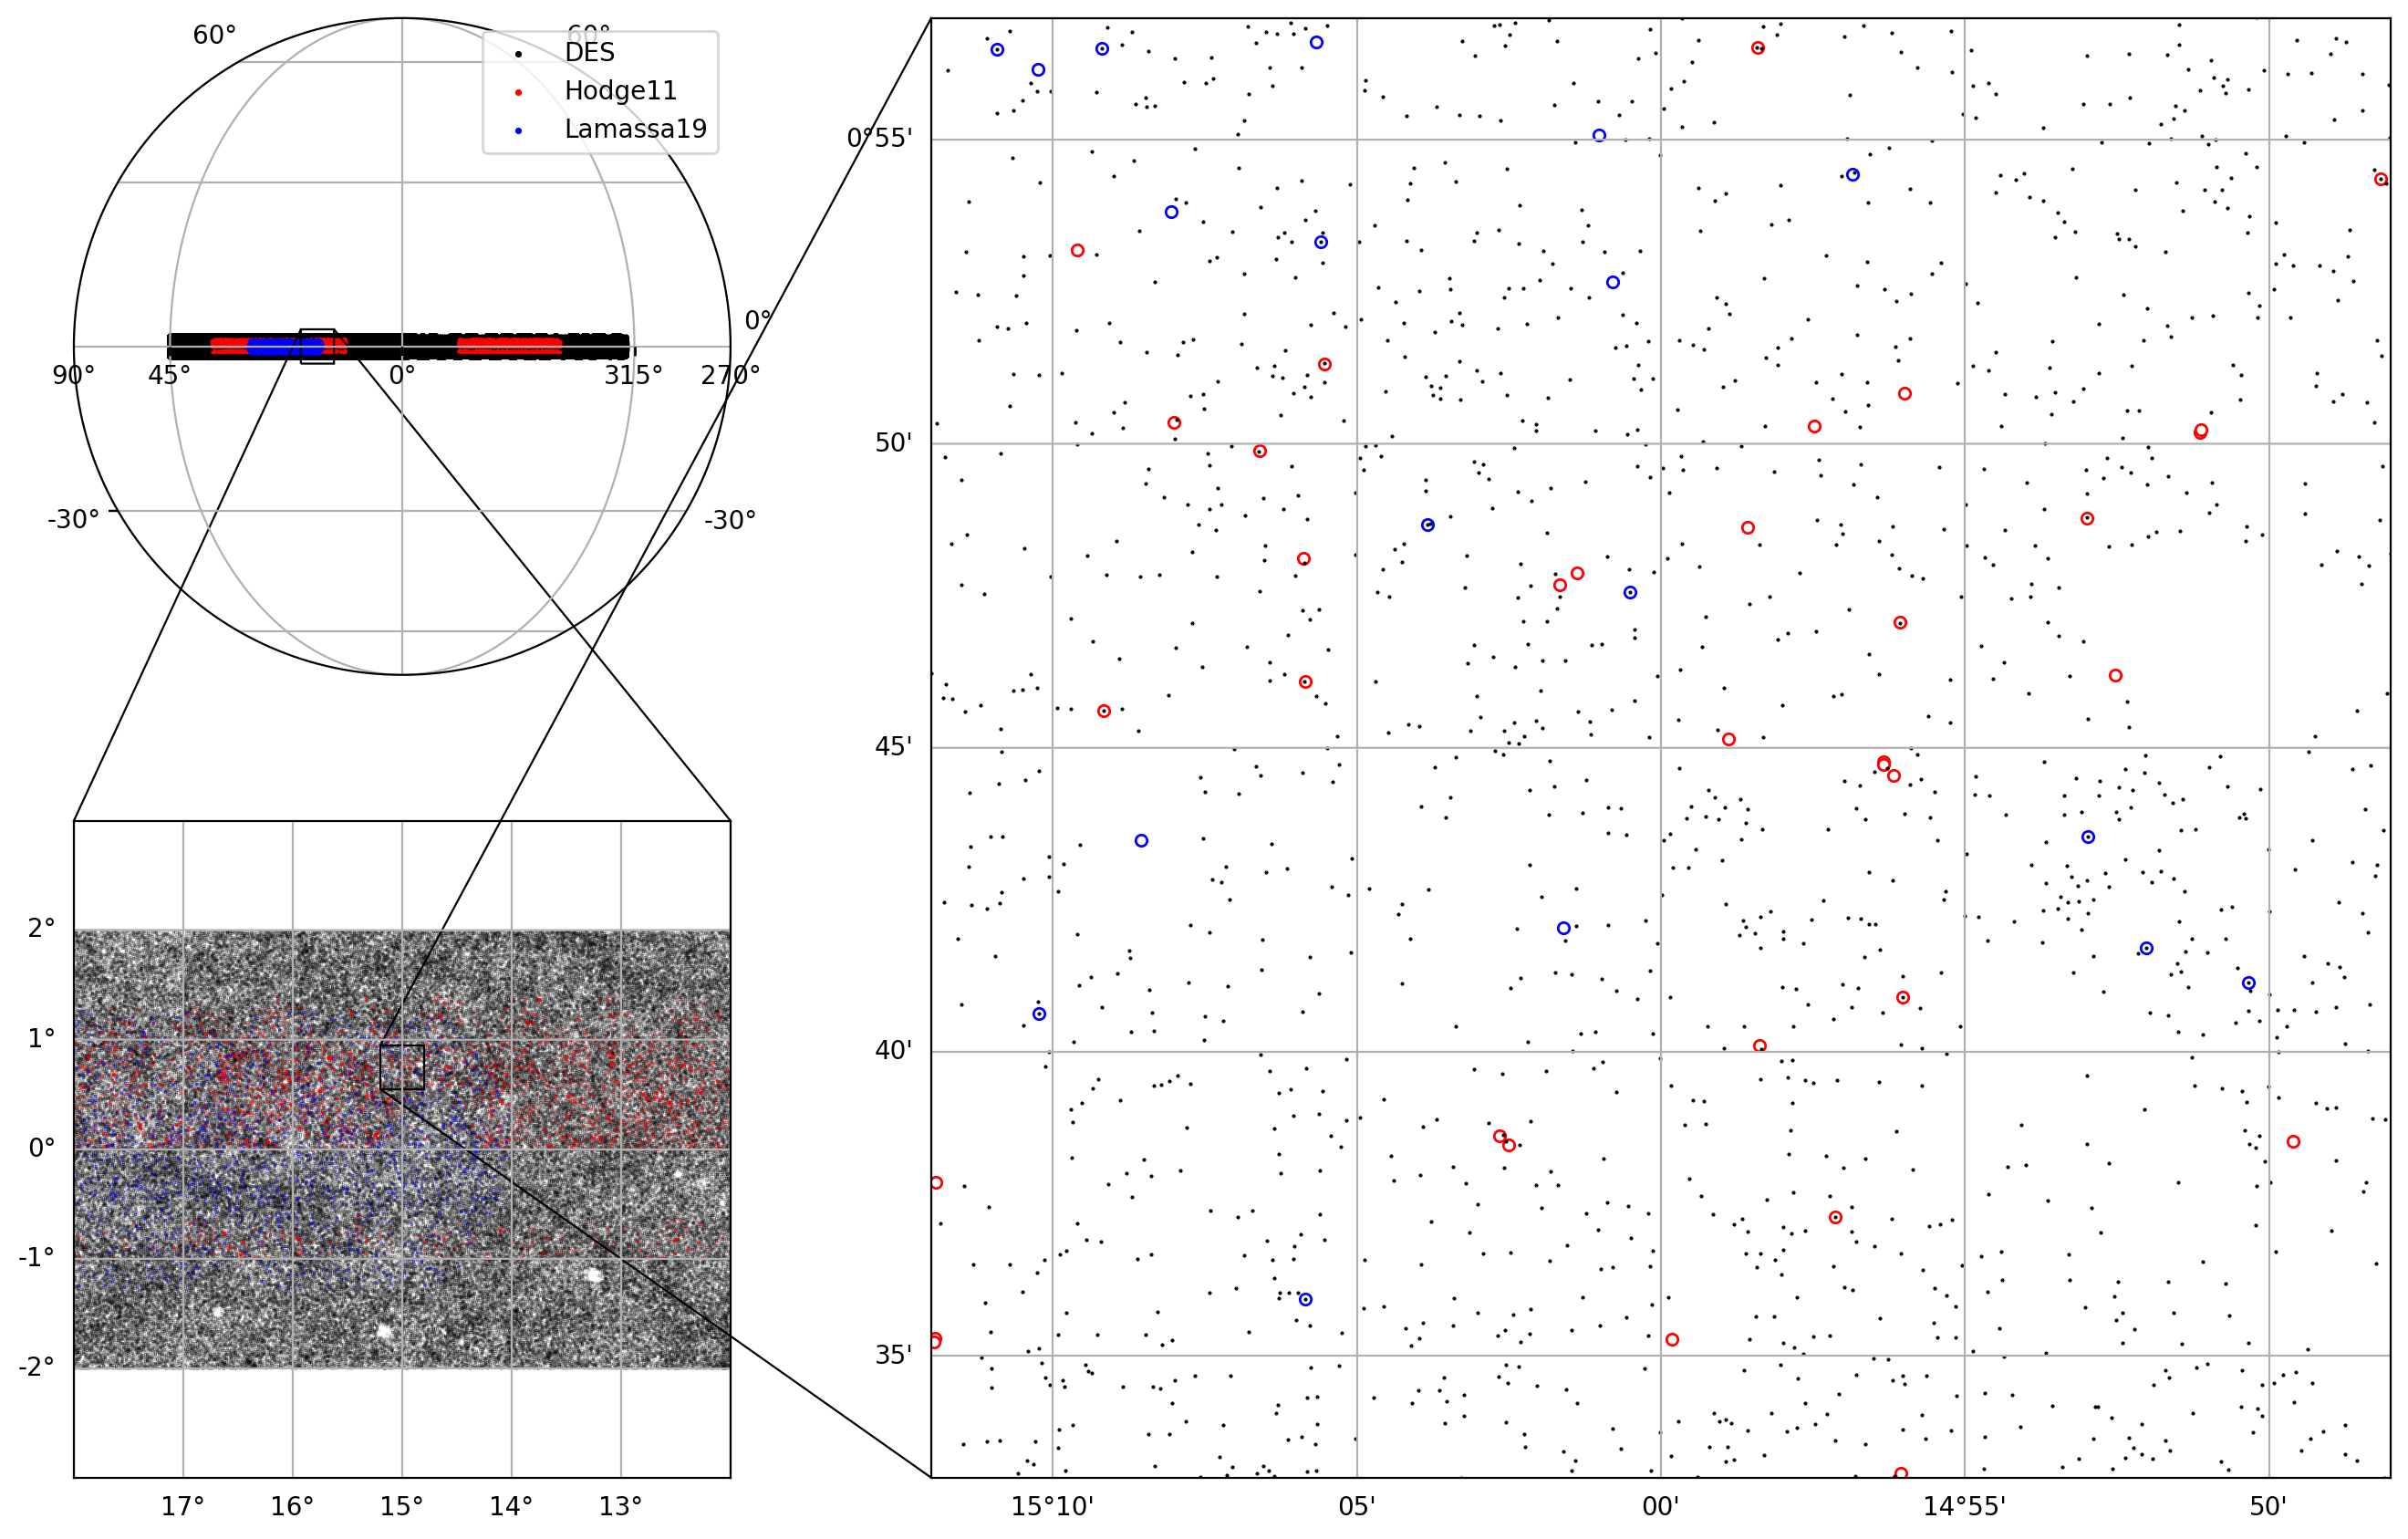

In [72]:
fig = plt.figure(figsize=[12, 8], dpi=100)
ax = plt.axes([0, 0.55, 0.45, 0.45], projection='astro degrees globe')
ax_in = plt.axes([0, 0, 0.45, 0.45], projection='astro degrees zoom', center='15d 0d', radius='3 deg')
ax_in_in = plt.axes([0.3, 0, 1, 1], projection='astro degrees zoom', center='15d 0d45m', radius='0.2 deg')

ax.scatter(ra,                  dec,                    s=0.1,    marker='.', label='DES',        color='k', transform=ax.get_transform('world'))
ax.scatter(Hodge11_coord.ra,    Hodge11_coord.dec,      s=0.1,     marker='.', label='Hodge11',        color='r', transform=ax.get_transform('world'))
ax.scatter(Lamassa19_coord.ra,  Lamassa19_coord.dec,    s=0.1,      marker='.', label='Lamassa19',      color='b', transform=ax.get_transform('world'))

ax_in.scatter(ra,                   dec,                    s=0.01, marker='.', label='DES',        color='k', transform=ax_in.get_transform('world'))
ax_in.scatter(Hodge11_coord.ra,     Hodge11_coord.dec,      s=0.1,  marker='.', label='Hodge11',        color='r', transform=ax_in.get_transform('world'))
ax_in.scatter(Lamassa19_coord.ra,   Lamassa19_coord.dec,    s=0.1,  marker='.', label='Lamassa19',      color='b', transform=ax_in.get_transform('world'))

ax_in_in.scatter(Lamassa19_coord.ra,    Lamassa19_coord.dec,    s=20,   marker='o', c='w',  edgecolors='b', label='Lamassa19',  transform=ax_in_in.get_transform('world'))
ax_in_in.scatter(Hodge11_coord.ra,      Hodge11_coord.dec,      s=20,   marker='o', c='w',  edgecolors='r', label='Hodge11',    transform=ax_in_in.get_transform('world'))
ax_in_in.scatter(ra,                    dec,                    s=1,    marker='.', color='k',              label='DES',    transform=ax_in_in.get_transform('world'))

ax.grid()
ax.legend(markerscale=10)
ax.mark_inset_axes(ax_in)
ax.connect_inset_axes(ax_in, 'upper left')
ax.connect_inset_axes(ax_in, 'upper right')
ax_in.grid()
ax_in.coords['ra'].set_ticks_visible(False)
ax_in.coords['dec'].set_ticks_visible(False)
ax_in.coords['ra'].set_auto_axislabel(False)
ax_in.coords['dec'].set_auto_axislabel(False)
ax_in.mark_inset_axes(ax_in_in)
ax_in.connect_inset_axes(ax_in_in, 'upper left')
ax_in.connect_inset_axes(ax_in_in, 'lower left')
ax_in_in.grid()
ax_in_in.coords['ra'].set_ticks_visible(False)
ax_in_in.coords['dec'].set_ticks_visible(False)
ax_in_in.coords['ra'].set_auto_axislabel(False)
ax_in_in.coords['dec'].set_auto_axislabel(False)
plt.show()

## Plot Chi2

In [7]:
float_chi2 = cigale_float['best.reduced_chi_square']
fagn0_chi2 = cigale_fagn0['best.reduced_chi_square']
redshift = src_table['redshift']

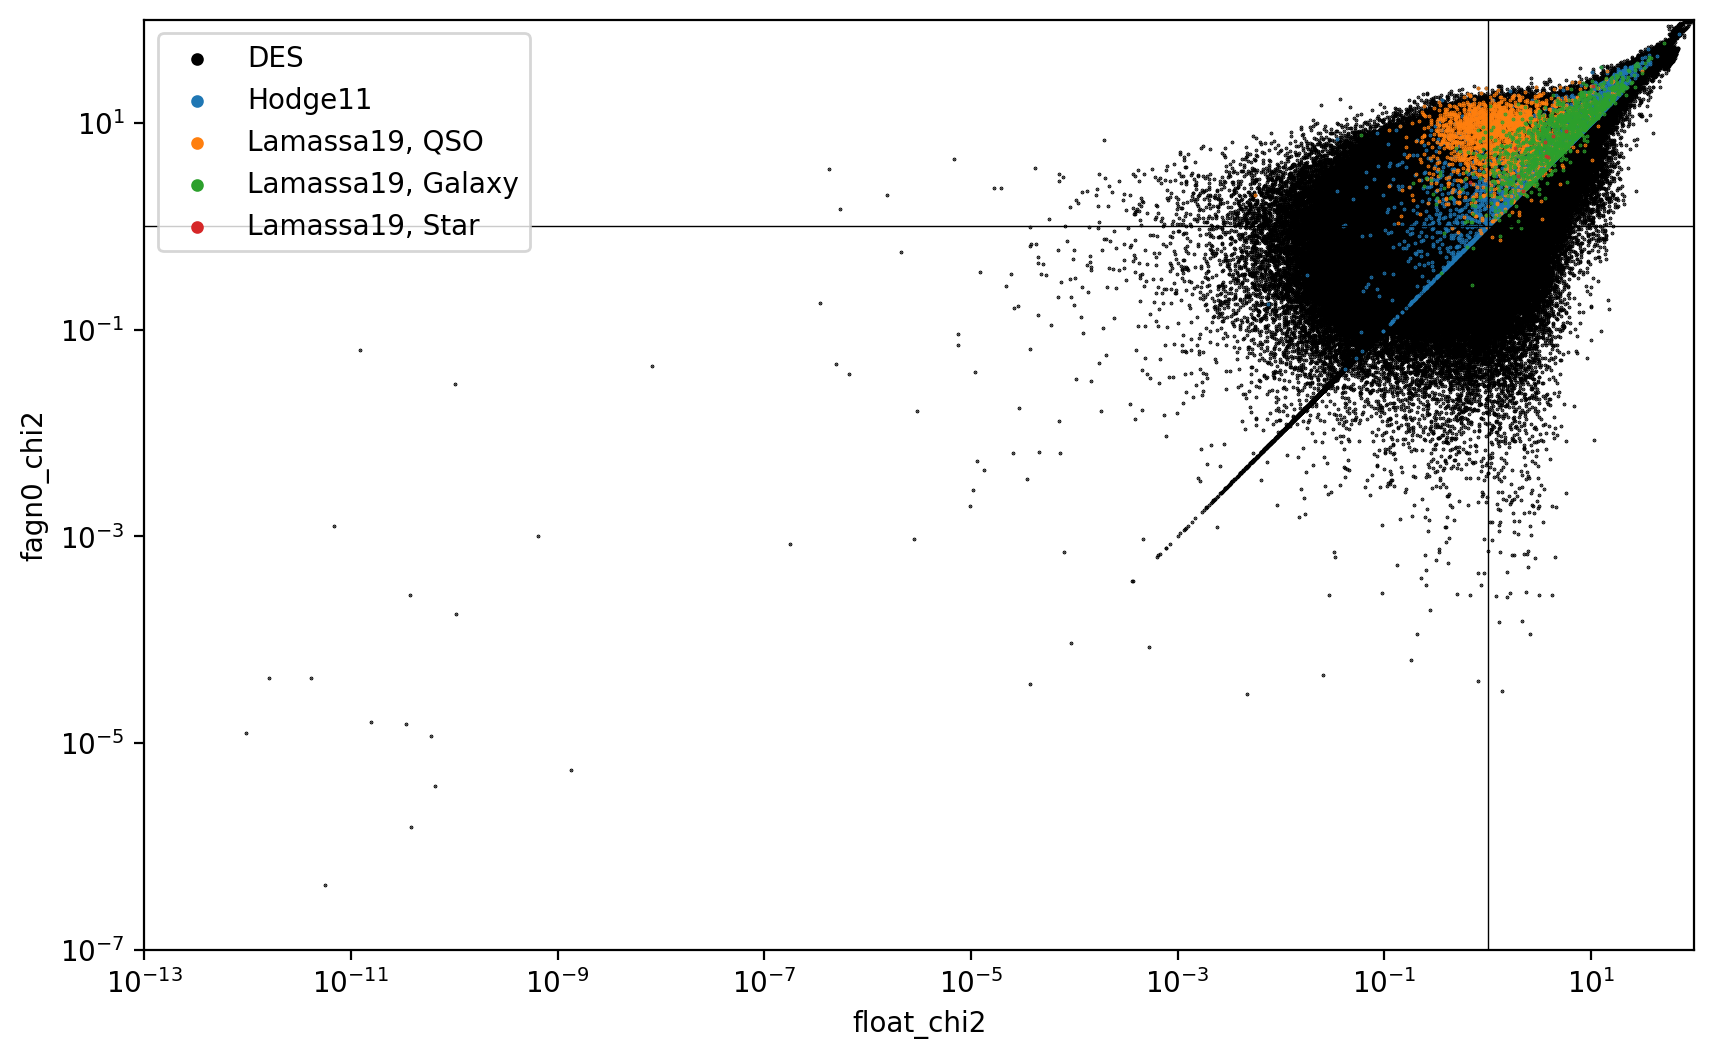

In [260]:
fig, ax = plt.subplots(figsize=[10, 10])

plt.scatter(float_chi2,                     fagn0_chi2,                     marker='.', s=0.5,  label='DES', color='k')
plt.scatter(float_chi2[Hodge11_sel],        fagn0_chi2[Hodge11_sel],        marker='.', s=0.5,  label='Hodge11')
plt.scatter(float_chi2[Lamassa19QSO_sel],   fagn0_chi2[Lamassa19QSO_sel],   marker='.', s=0.5,  label='Lamassa19, QSO')
plt.scatter(float_chi2[Lamassa19Gal_sel],   fagn0_chi2[Lamassa19Gal_sel],   marker='.', s=0.5,  label='Lamassa19, Galaxy')
plt.scatter(float_chi2[Lamassa19Star_sel],  fagn0_chi2[Lamassa19Star_sel],  marker='.', s=0.5,  label='Lamassa19, Star')

plt.xlim(1e-13, 100)
plt.ylim(1e-7, 100)
ax.set_aspect(1)
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel('float_chi2')
plt.ylabel('fagn0_chi2')
# plt.axline((0, 0), slope=1, color='k', linewidth=0.5)
plt.hlines(xmin=0, xmax=100, y=1, color='k', linewidth=0.5)
plt.vlines(ymin=0, ymax=100, x=1, color='k', linewidth=0.5)
plt.legend(loc='upper left', markerscale=10)
plt.show()

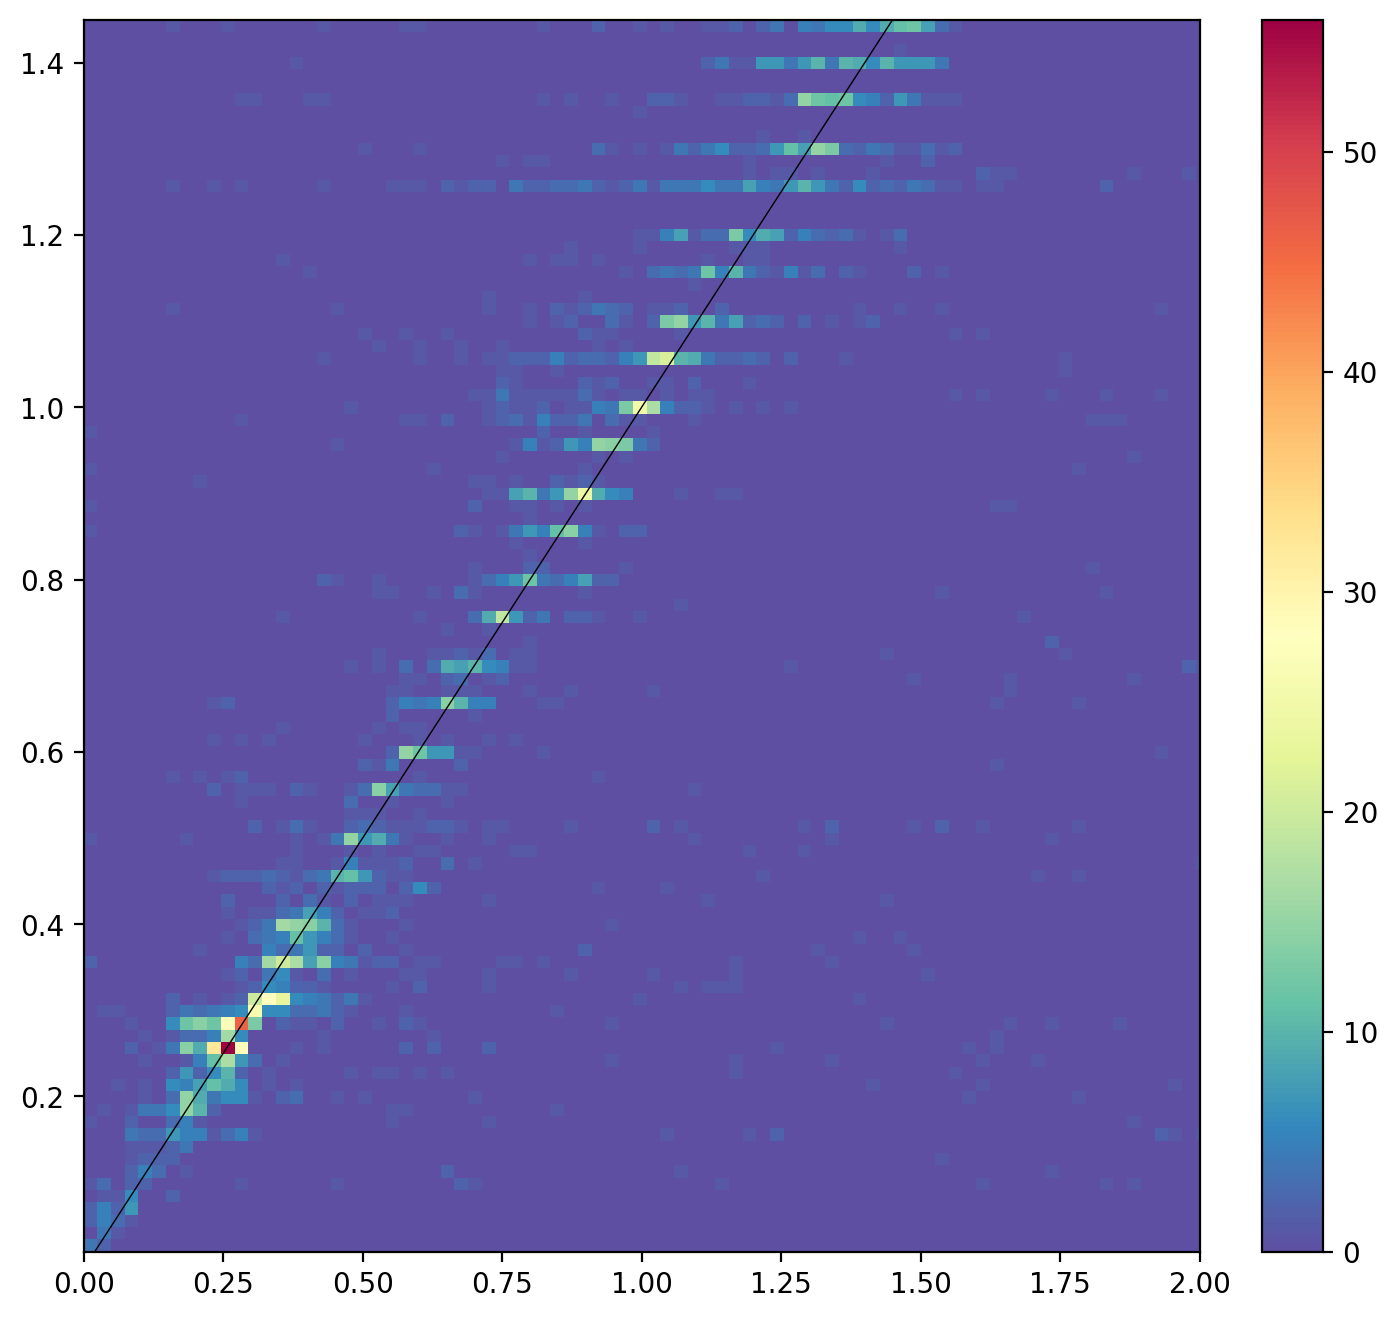

In [246]:
from scipy.stats import gaussian_kde

fig, ax = plt.subplots(figsize=[8, 8])

plt.hist2d(Lamassa19[idx[Lamassa19_sel]]['redshift'], redshift[Lamassa19_sel], bins=[150, 100])
plt.xlim(None, 2)

# data = np.vstack([Lamassa19[idx[Lamassa19_sel]]['redshift'], redshift[Lamassa19_sel]])
# kde = gaussian_kde(data, bw_method=0.05)
# X, Y = np.meshgrid(np.linspace(0, 2, 1000), np.linspace(0, 2, 1000))
# Z = kde.evaluate(np.vstack([X.ravel(), Y.ravel()]))
# plt.imshow(Z.reshape(X.shape), origin='lower', extent=[0, 2, 0, 2])
# ax.set_aspect(1)

plt.axline((0, 0), slope=1, color='k', linewidth=0.5)
plt.colorbar(fraction=0.05, pad=0.05)

plt.show()

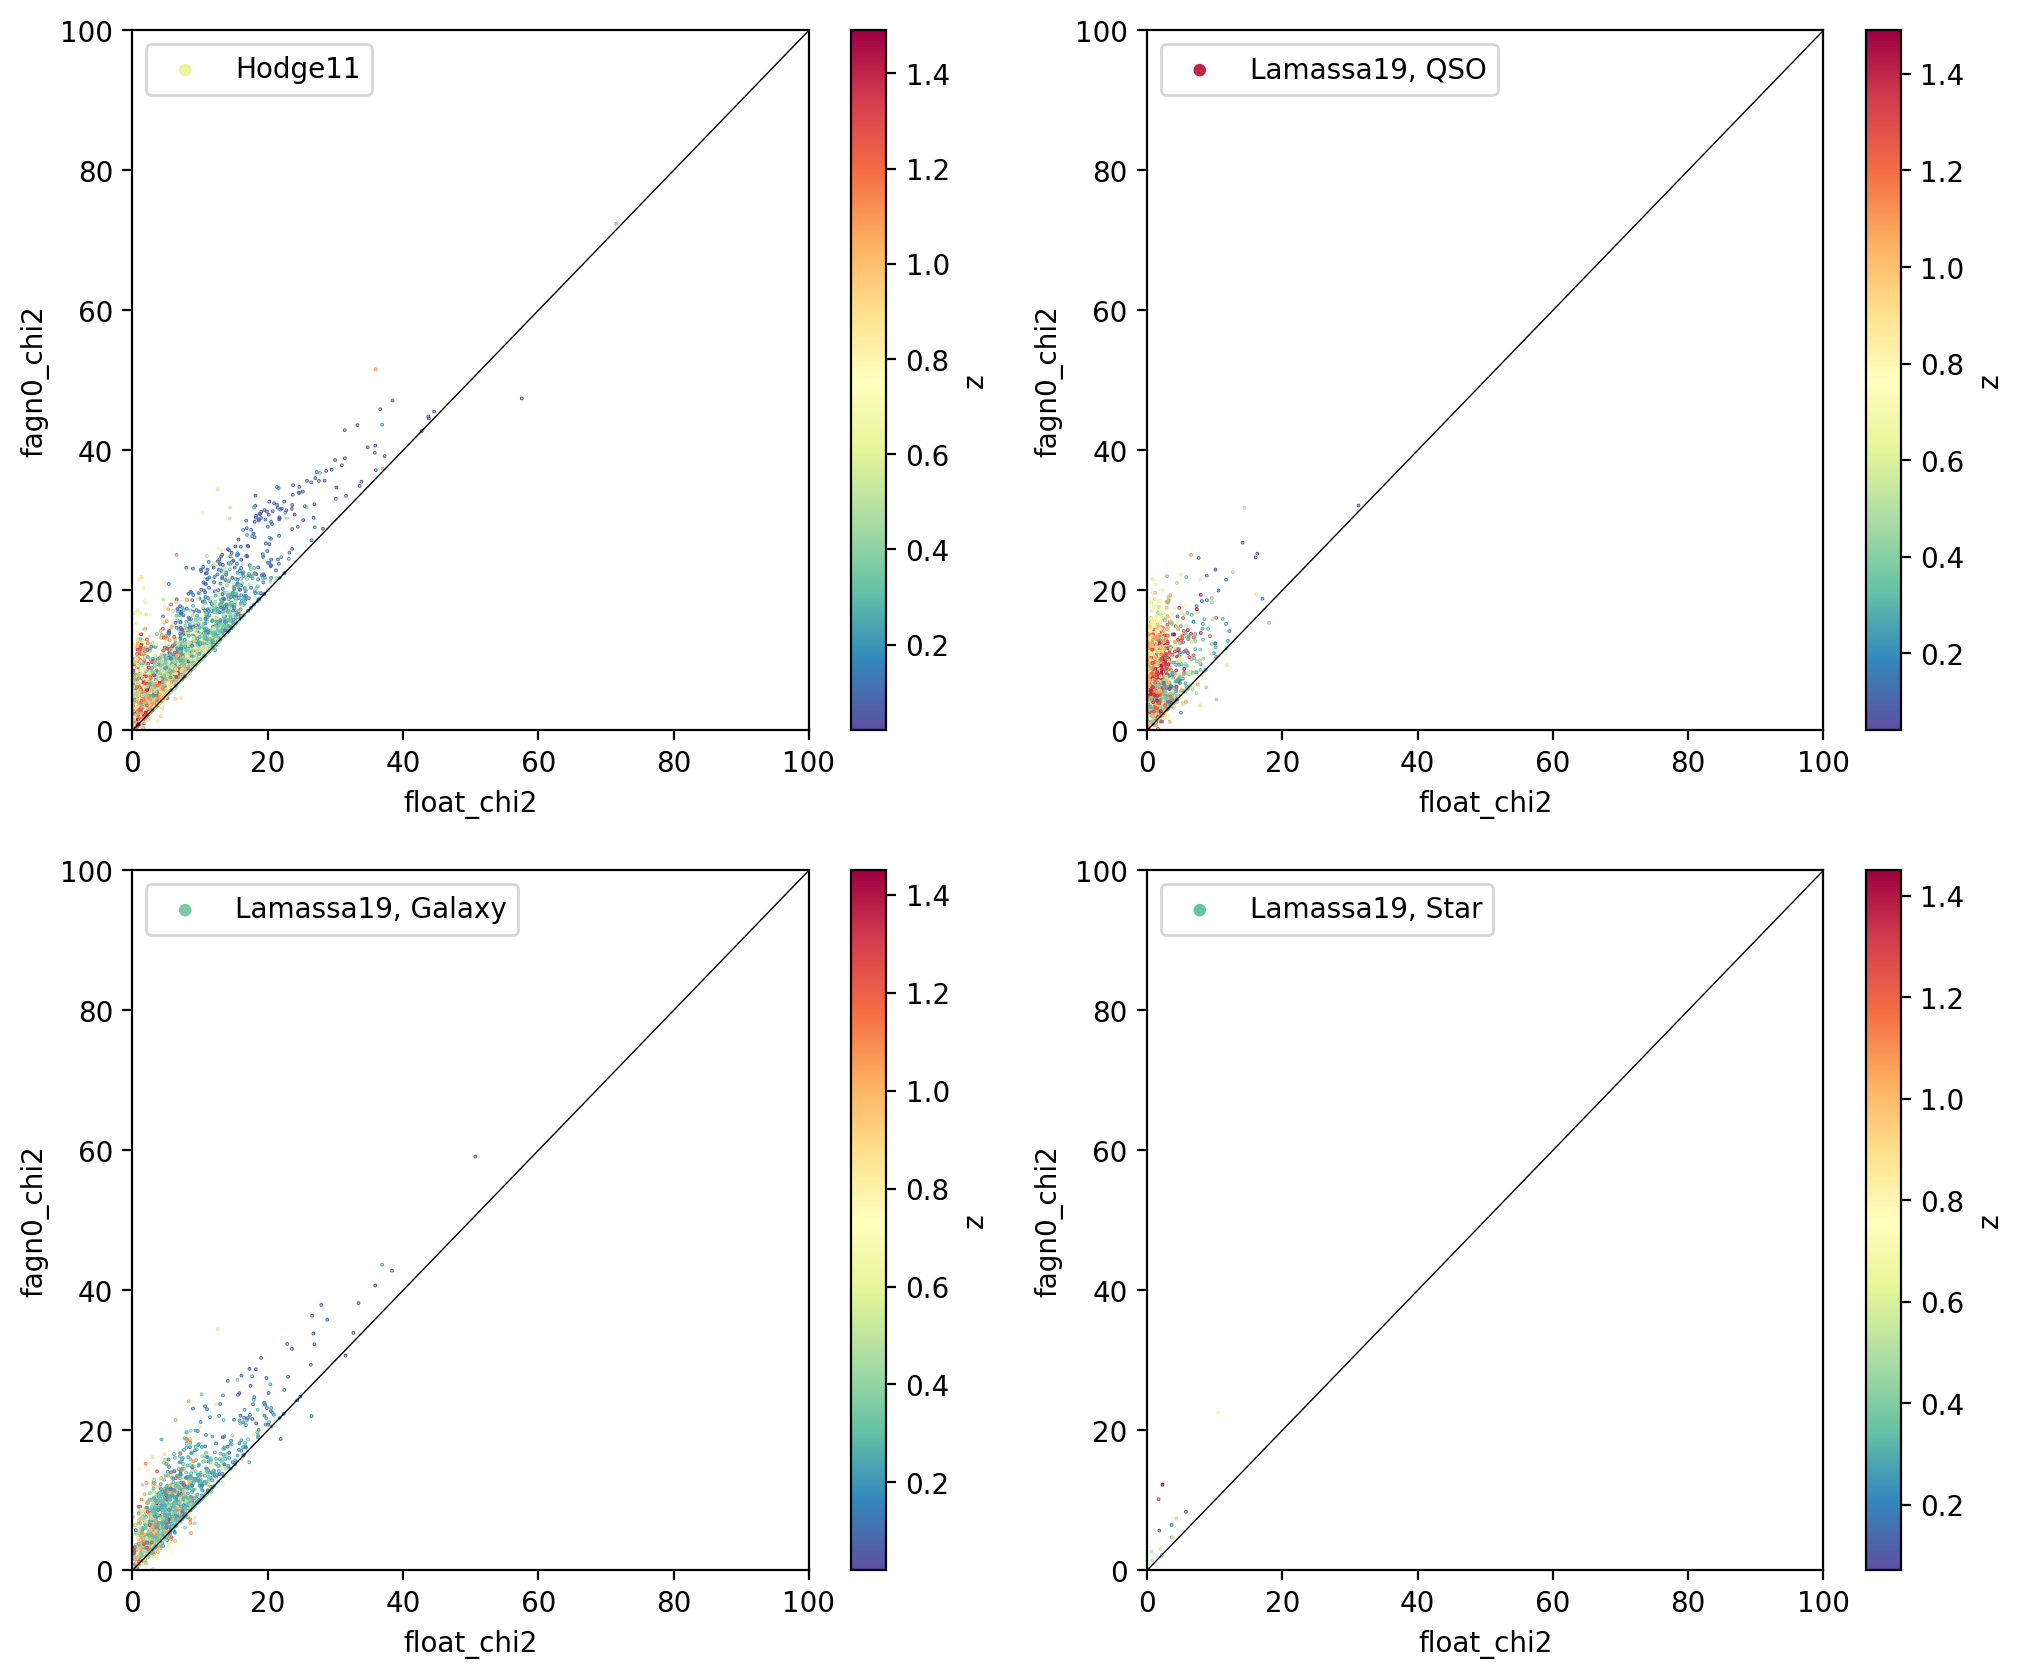

In [112]:
fig, axs = plt.subplots(2, 2, figsize=[12, 10])

for ax, sel, label in zip(axs.reshape(4), [Hodge11_sel, Lamassa19QSO_sel, Lamassa19Gal_sel, Lamassa19Star_sel], \
                          ['Hodge11', 'Lamassa19, QSO', 'Lamassa19, Galaxy', 'Lamassa19, Star']): 
    im = ax.scatter(float_chi2[sel], fagn0_chi2[sel], marker='.', s=0.5,  label=label, c=redshift[sel], cmap='Spectral_r')
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.set_xlabel('float_chi2')
    ax.set_ylabel('fagn0_chi2')
    ax.axline((0, 0), slope=1, color='k', linewidth=0.5)
    ax.legend(loc='upper left', markerscale=10)
    cb = plt.colorbar(im)
    cb.set_label('z')

plt.show()

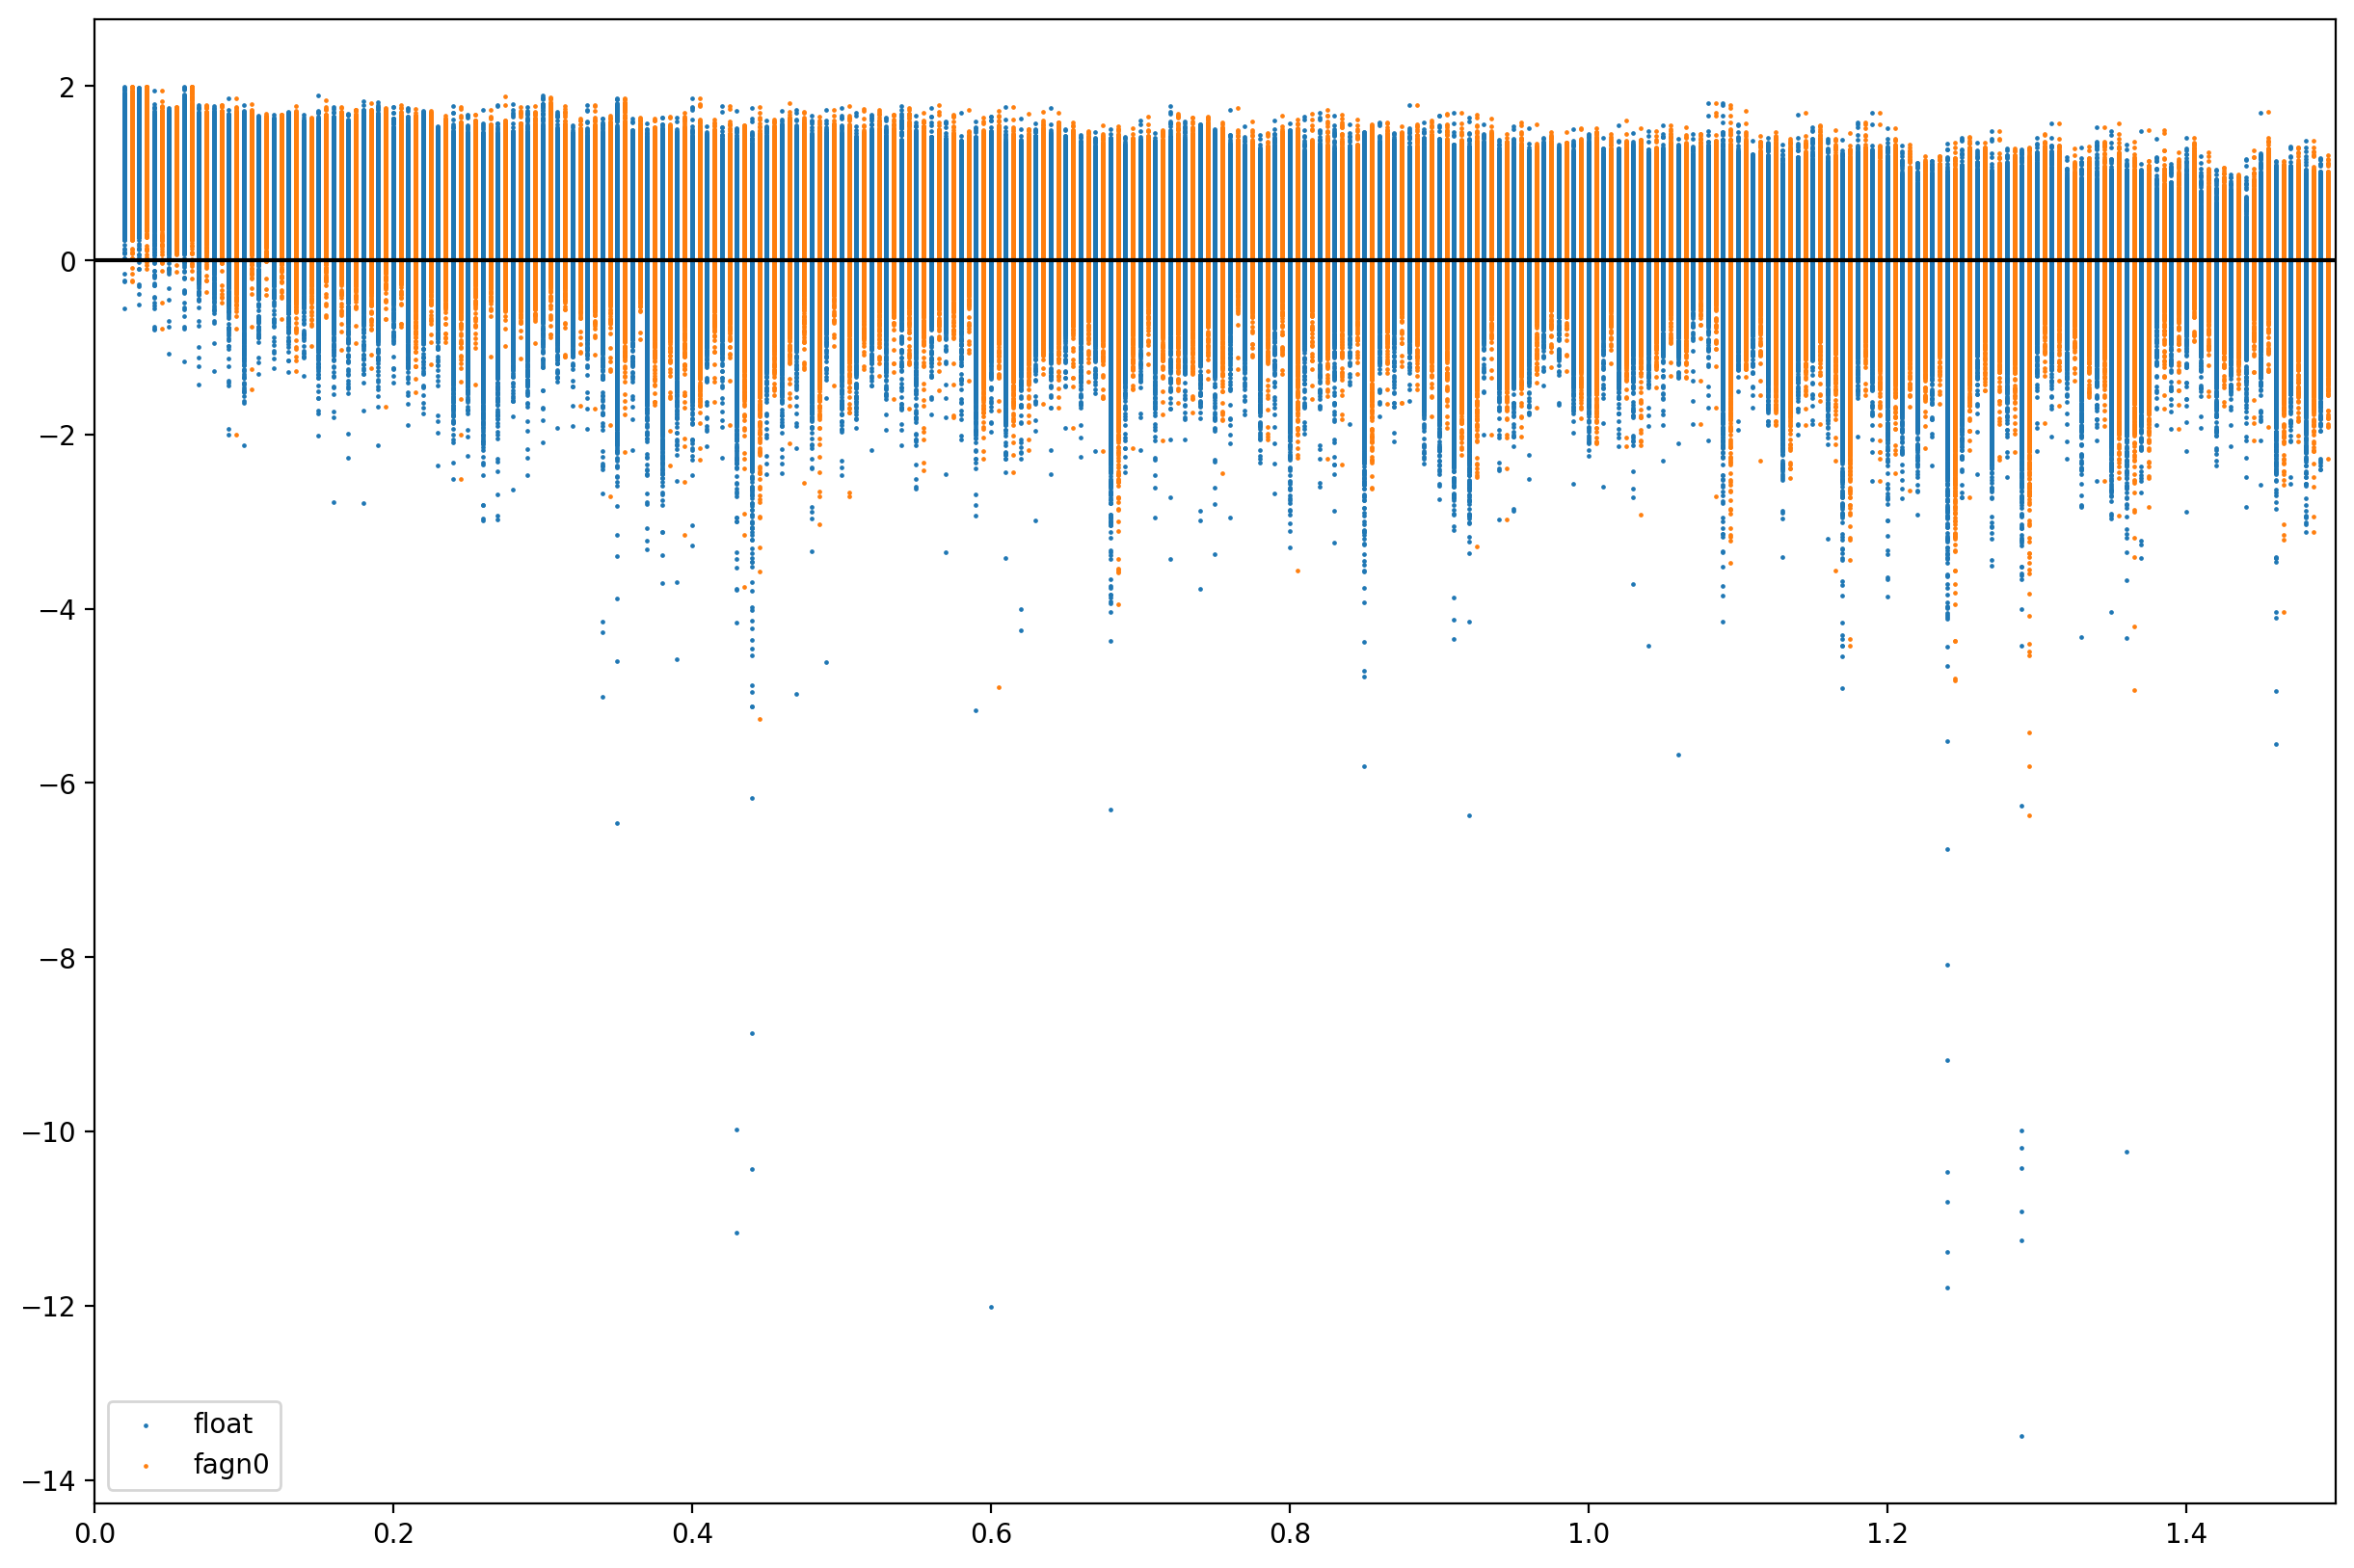

In [9]:
fig = plt.figure(figsize=[15, 10])
plt.scatter(redshift, np.log10(float_chi2), marker='.', s=2, label='float')
plt.scatter(redshift+0.005, np.log10(fagn0_chi2), marker='.', s=2, label='fagn0')

plt.xlim(0, 1.5)
plt.hlines(y=0, xmin=0, xmax=1.5, colors='k')
plt.legend()

plt.show()

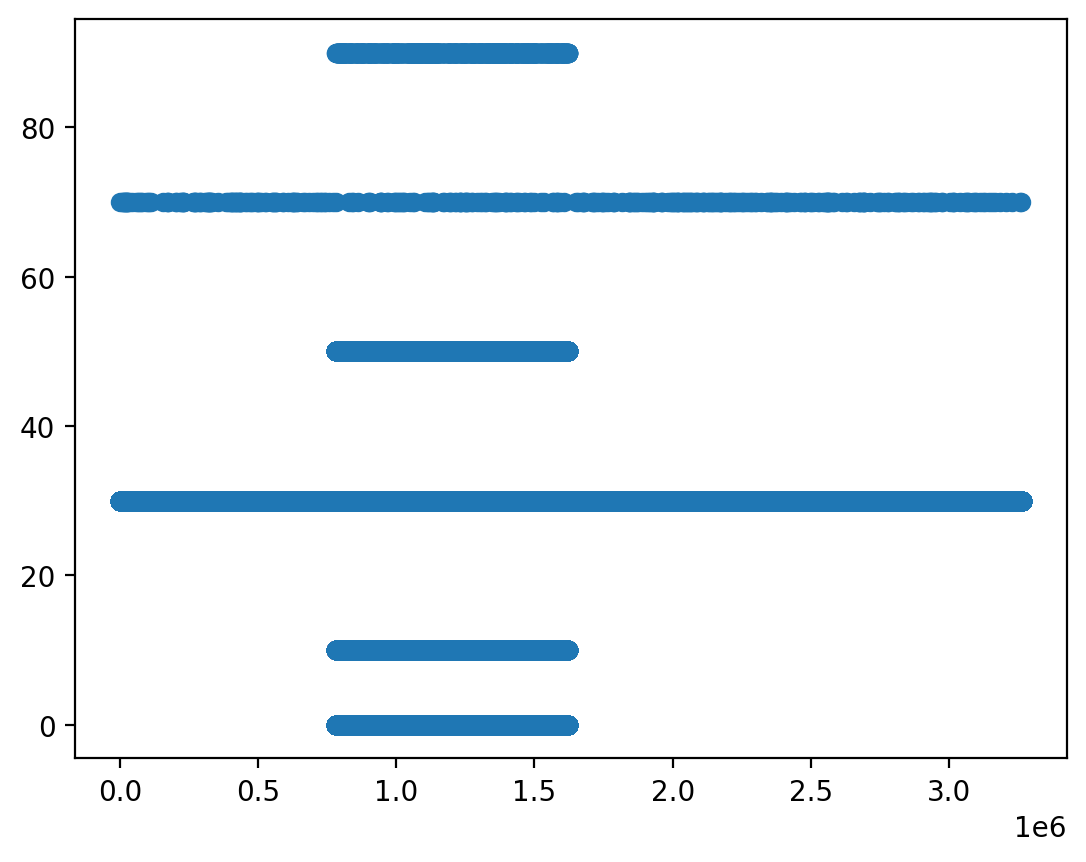

In [267]:
plt.scatter(range(len(cigale_float['best.agn.i'])), cigale_float['best.agn.i'])

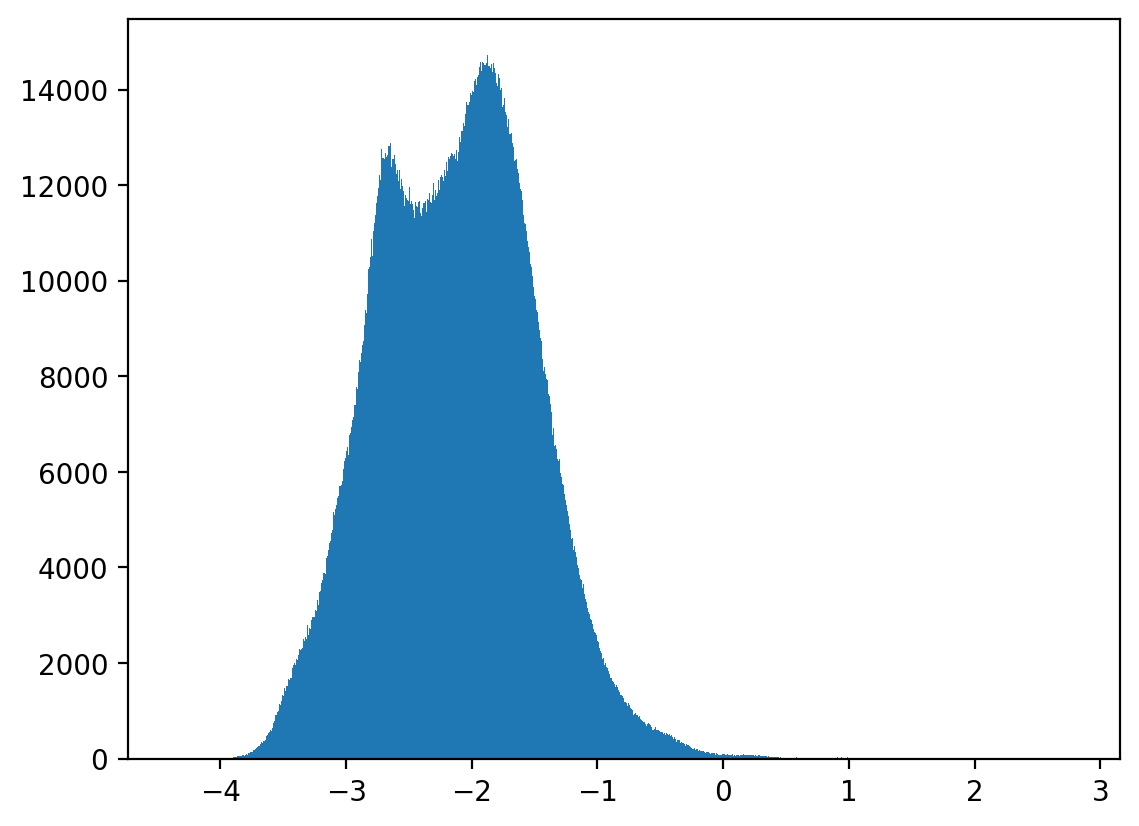

In [272]:
_=plt.hist(np.log10(cigale_float['best.i_prime']), bins=1000)